# $ \textit{Calculating Configurational entropies from GMM objects}$

### $\textit{Import Libraries}$

In [58]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [59]:
from MDAnalysis.lib.distances import calc_dihedrals
def calc_phi_psi(trajData):
    phis = calc_dihedrals(trajData[:,0,:], trajData[:,1,:], trajData[:,2,:], trajData[:,3,:])*180/3.14
    psis = calc_dihedrals(trajData[:,1,:], trajData[:,2,:], trajData[:,3,:], trajData[:,4,:])*180/3.14
    return phis,psis

### $\textit{Metadynamics simulation (BF=10)}$

### $\textit{Path to files}$

In [60]:
data_path = "/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf10/"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.colvars.dat"

### $\textit{Load Metad fbias from colvar}$

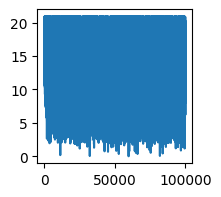

In [43]:
metad_fbias = np.loadtxt(data_path+"colvar_reweight", usecols=3)
metad_fbias -= metad_fbias.min()

plt.figure(figsize=(2,2))
plt.plot(metad_fbias)

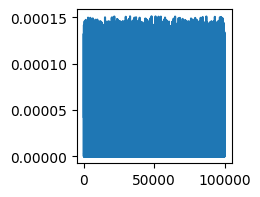

In [44]:
kt = 0.596161  # @ 300K in kcal/mol unit
fbias_weights  = np.exp(metad_fbias/kt)
fbias_weights /= np.sum(fbias_weights)

plt.figure(figsize=(2,2))
plt.plot(fbias_weights)

### $\textit{Load the GMM objects for different choice of weights}$

Loading uniform objects

In [45]:
objs_uniform = []
#for i in range(3):
for i in range(5):
    with open(data_path+"run_with_v1.6.1/wsgmm_%dstate_wout_weights_nattempts_40.pickle"%(i+2), "rb") as fo:
        obj_ = pickle.load(fo)
    objs_uniform.append(obj_)
    
objs_uniform = np.array(objs_uniform)
print(objs_uniform.shape)

(5,)


Loading objects from other choice of weights

In [46]:
wsgmm_list = []

# loop over different weights (w1:= bias, w2:= rbias and w3:= fbias)
for i in range(3):
    objs = []
    
    # loop over different clusters (2,3,4)
    #for j in range(3):
    for j in range(5):
        
        # load pickled object
        with open(data_path+"w%d/run_with_v1.6.1/kabsch_thresh_1e-1/wsgmm_%dstate_nattempts_40.pickle"%(i+1, j+2), "rb") as fo:
            obj = pickle.load(fo)
        
        objs.append(obj)
    
    wsgmm_list.append(objs)
        
wsgmm_list = np.array(wsgmm_list)
print(wsgmm_list.shape)

(3, 5)


In [47]:
#all_wsgmm = np.concatenate([objs_uniform.reshape(1,3), wsgmm_list], axis=0)
all_wsgmm = np.concatenate([objs_uniform.reshape(1,5), wsgmm_list], axis=0)

print(all_wsgmm.shape)

(4, 5)


### $\textit{Lets create the modified uniform objects}$

Hard code the cluster populations from fbias weights

In [48]:
## making a copy of uniform objects 
#uniform_modf_objs = all_wsgmm[0,:].copy().reshape(1,3)
uniform_modf_objs = all_wsgmm[0,:].copy().reshape(1,5)

print(uniform_modf_objs.shape)

(1, 5)


In [49]:
print("Original Weights for each of the uniform objects:\n")
#for j in range(3):
for j in range(5):
    print("%d cluster: "%(j+2), all_wsgmm[0,j].weights)

Original Weights for each of the uniform objects:

2 cluster:  [0.9187048 0.0812952]
3 cluster:  [0.35271946 0.3324601  0.31482044]
4 cluster:  [0.33975473 0.27061529 0.23671324 0.15291675]
5 cluster:  [0.29853009 0.27504356 0.21523758 0.13976213 0.07142664]
6 cluster:  [3.14788718e-01 2.59534446e-01 2.39811606e-01 1.85795758e-01
 5.94719141e-05 9.99990000e-06]


In [50]:
print("Original Weights for each of the fbias weight objects:\n")
#for j in range(3):
for j in range(5):
    print("%d cluster: "%(j+2), all_wsgmm[3,j].weights)

Original Weights for each of the fbias weight objects:

2 cluster:  [0.55865813 0.44134187]
3 cluster:  [0.5131445 0.4683594 0.0184961]
4 cluster:  [0.4322426  0.3621806  0.18708089 0.01849591]
5 cluster:  [0.28425596 0.27785684 0.22222823 0.19716292 0.01849604]
6 cluster:  [0.41034481 0.30439397 0.16123026 0.10553483 0.01219767 0.00629845]


In [51]:
print("Modified weights for uniform objects:\n")
# loop over sizes 2,3 and 4 (uniform GMM objects)
#for i in range(3):
for i in range(5):
    obj_i = all_wsgmm[0,i]
    wgts = np.empty(obj_i.n_clusters)
    
    # loop over num clusters in each GMM object
    for j in range(obj_i.n_clusters):
        wgts[j] = np.sum(fbias_weights[[x[0] for x in np.argwhere(obj_i.cluster_ids == j)]])
    
    # assign the newly calculated weights !
    uniform_modf_objs[0,i].weights = wgts    
    print("%d cluster: "%(i+2), wgts)

Modified weights for uniform objects:

2 cluster:  [0.99434779 0.00565221]
3 cluster:  [0.23604636 0.54791274 0.2160409 ]
4 cluster:  [0.57484136 0.01834223 0.34939254 0.05742387]
5 cluster:  [0.45953646 0.20583064 0.25952673 0.06031051 0.01479567]
6 cluster:  [5.48468245e-01 3.43984125e-01 1.84959719e-02 8.90516554e-02
 4.37242368e-14 2.78614494e-09]


### $\textit{Combine all the GMMs together now}$

In [52]:
# uniform -> bias -> rbias -> fbias -> uniform_modf (This is the order along 0 axis)
all_wsgmm_combined = np.concatenate([all_wsgmm, uniform_modf_objs], axis=0)  
print(all_wsgmm_combined.shape)

(5, 5)


### $\textit{Function for performing 2D numerical integration}$

In [53]:
def numerical_integration_2d_simp(fxy,dx,dy):
    #dx and dy could be backwards, but probably identical here
    int_x = np.array([ np.trapz(fxy_i,dx=dx) for fxy_i in fxy ])
    return np.trapz(int_x,dx=dy)

### $\textit{load the Metad reference FE for BF=10 simulation}$

In [54]:
metad_fe_sumhills = np.loadtxt(os.path.join(data_path,"2d_fe_phi_psi_sum_hill_bf10_nbins_100.txt"))[:,2]
metad_fe_sumhills = metad_fe_sumhills.reshape((100,100))

#  calculate the nomrlaized probability density 
dx = dy = 2*np.pi/len(metad_fe_sumhills)
prob_metad = np.exp(-metad_fe_sumhills/kt)
prob_metad = prob_metad/numerical_integration_2d_simp(prob_metad,dx,dy)  # normalized

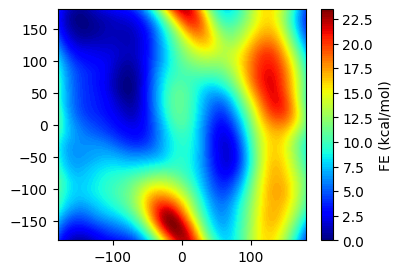

In [57]:
grids_ = np.linspace(-180, 180, 100, endpoint=True, dtype=float)
plt.figure(figsize=(4,3))
plt.contourf(grids_, grids_, metad_fe_sumhills, cmap=plt.get_cmap("jet"), levels=100)
cbar = plt.colorbar()
cbar.set_label("FE (kcal/mol)")

## $\textit{S$_{config}$ for Ground Truth}$

In [17]:
locs = np.nonzero(prob_metad.T.flatten())
S_ref = dx*dy*np.sum(prob_metad.T.flatten()[locs]*(np.log(prob_metad.T.flatten()[locs])))
print("Conigurational Entropy for GT= ", S_ref)

Conigurational Entropy for GT=  -1.0879662775166619


## $\textit{calculate S$_{config}$ for all GMM objects by integrating all space}$ 

In [18]:
from shapeGMMTorch import similarities as sm

In [19]:
num_samples = 1000000  # 1M samples
S_config_all = np.zeros([all_wsgmm_combined.shape[0], all_wsgmm_combined.shape[1]])

for i in range(all_wsgmm_combined.shape[0]):
    for j in range(all_wsgmm_combined.shape[1]):
        all_wsgmm_combined[i,j].device = "cpu"
        S_config_all[i,j] = sm.configurational_entropy(all_wsgmm_combined[i,j], n_points=num_samples)[0]

print("Configurational Entropies (all): \n", S_config_all)

Configurational Entropies (all): 
 [[43.12544939 55.02468127 55.96272221 55.33515733 55.90894127]
 [58.71385013 59.7263472  60.41080449 61.01982639 61.44010854]
 [58.61144214 60.01207617 60.64230191 61.06923379 60.94503501]
 [58.67150763 60.04222813 60.34279791 60.93067555 61.06024796]
 [43.12532024 55.02682317 55.95976985 55.33266165 55.90882048]]


## $\textit{calculate S$_{config}$ for all GMM objects by integrating 2D phi-psi space}$ 

In [20]:
num_samples = 1000000  # 1M samples 
nbins = [100,100]
range_ = [-180,180]

S_config_2d = np.zeros([all_wsgmm_combined.shape[0], all_wsgmm_combined.shape[1]])

for i in range(all_wsgmm_combined.shape[0]):
    for j in range(all_wsgmm_combined.shape[1]):
        all_wsgmm_combined[i,j].device = "cpu"
        
        # generate trajetory
        traj = all_wsgmm_combined[i,j].generate(num_samples)
        
        # calculate dihedrals
        phis, psis = calc_phi_psi(traj)
            
        # histogram
        hist = np.histogram2d(phis, psis, bins=nbins, range=[range_, range_], density=True)[0]
        hist = hist/numerical_integration_2d_simp(hist,dx,dy)  # normalized
        
        # get the S_config_2d
        #S_config_2d[i,j] = numerical_integration_2d_simp(hist*np.log(hist), dx, dy)   # giving nan values mostly!
        
        locs = np.nonzero(hist.T.flatten())
        S_config_2d[i,j]  = dx*dy*np.sum(hist.T.flatten()[locs]*(np.log(hist.T.flatten()[locs])))

print("Configuartional Entropies (2D): \n", S_config_2d)

Configuartional Entropies (2D): 
 [[-3.51434295 -3.27133606 -2.56835631 -3.32795525 -2.61198669]
 [-0.74024087 -0.28176202 -0.2614884  -0.28619679 -0.33923085]
 [-0.77568305 -0.29112475 -0.26107979 -0.2998121  -0.25785576]
 [-0.74728867 -0.28067347 -0.266921   -0.3944218  -0.2834189 ]
 [-3.5157787  -3.27315366 -2.56988602 -3.32937728 -2.61190938]]


In [21]:
dS_config_all = S_config_all - S_ref
dS_config_2d = S_config_2d - S_ref

print("dS_config_all: \n", dS_config_all, '\n')
print("dS_config_2d: \n", dS_config_2d)

dS_config_all: 
 [[44.21341567 56.11264755 57.05068849 56.42312361 56.99690755]
 [59.80181641 60.81431348 61.49877077 62.10779267 62.52807482]
 [59.69940841 61.10004245 61.73026819 62.15720006 62.03300129]
 [59.75947391 61.13019441 61.43076419 62.01864182 62.14821424]
 [44.21328652 56.11478945 57.04773613 56.42062793 56.99678676]] 

dS_config_2d: 
 [[-2.42637667 -2.18336978 -1.48039003 -2.23998897 -1.52402041]
 [ 0.34772541  0.80620426  0.82647788  0.80176949  0.74873542]
 [ 0.31228323  0.79684153  0.82688649  0.78815418  0.83011051]
 [ 0.34067761  0.80729281  0.82104528  0.69354448  0.80454738]
 [-2.42781243 -2.18518738 -1.48191974 -2.241411   -1.5239431 ]]


In [22]:
def print_tabular(dS):
    dS = dS.T
    y = dS.shape[0]
    x = dS.shape[1]
    
    x_labels = ["uniform", "bias", "rbias", "fbias", "uniform_modf"]
    #y_labels = ["Sizes", "K=2", "K=3", "K=4"]
    y_labels = ["Sizes", "K=2", "K=3", "K=4", "K=5", "K=6"]
    
    for i in range(y+1):
        if i == 0:
            print("size|     ", "     ".join(x_labels))
            print("--"*33)
        else:
            print(y_labels[i], "|", dS[i-1,:])

In [23]:
print("dS_config_2d :\n")
print_tabular(dS_config_2d)

dS_config_2d :

size|      uniform     bias     rbias     fbias     uniform_modf
------------------------------------------------------------------
K=2 | [-2.42637667  0.34772541  0.31228323  0.34067761 -2.42781243]
K=3 | [-2.18336978  0.80620426  0.79684153  0.80729281 -2.18518738]
K=4 | [-1.48039003  0.82647788  0.82688649  0.82104528 -1.48191974]
K=5 | [-2.23998897  0.80176949  0.78815418  0.69354448 -2.241411  ]
K=6 | [-1.52402041  0.74873542  0.83011051  0.80454738 -1.5239431 ]


In [24]:
print("dS_config_2d * -1: \n")
print_tabular(dS_config_2d*-1)

dS_config_2d * -1: 

size|      uniform     bias     rbias     fbias     uniform_modf
------------------------------------------------------------------
K=2 | [ 2.42637667 -0.34772541 -0.31228323 -0.34067761  2.42781243]
K=3 | [ 2.18336978 -0.80620426 -0.79684153 -0.80729281  2.18518738]
K=4 | [ 1.48039003 -0.82647788 -0.82688649 -0.82104528  1.48191974]
K=5 | [ 2.23998897 -0.80176949 -0.78815418 -0.69354448  2.241411  ]
K=6 | [ 1.52402041 -0.74873542 -0.83011051 -0.80454738  1.5239431 ]


In [25]:
print("dS_config_all :\n")
print_tabular(dS_config_all)

dS_config_all :

size|      uniform     bias     rbias     fbias     uniform_modf
------------------------------------------------------------------
K=2 | [44.21341567 59.80181641 59.69940841 59.75947391 44.21328652]
K=3 | [56.11264755 60.81431348 61.10004245 61.13019441 56.11478945]
K=4 | [57.05068849 61.49877077 61.73026819 61.43076419 57.04773613]
K=5 | [56.42312361 62.10779267 62.15720006 62.01864182 56.42062793]
K=6 | [56.99690755 62.52807482 62.03300129 62.14821424 56.99678676]


In [26]:
print("S_config_2d :\n")
print_tabular(S_config_2d)

S_config_2d :

size|      uniform     bias     rbias     fbias     uniform_modf
------------------------------------------------------------------
K=2 | [-3.51434295 -0.74024087 -0.77568305 -0.74728867 -3.5157787 ]
K=3 | [-3.27133606 -0.28176202 -0.29112475 -0.28067347 -3.27315366]
K=4 | [-2.56835631 -0.2614884  -0.26107979 -0.266921   -2.56988602]
K=5 | [-3.32795525 -0.28619679 -0.2998121  -0.3944218  -3.32937728]
K=6 | [-2.61198669 -0.33923085 -0.25785576 -0.2834189  -2.61190938]
